In [5]:
import torch
import random
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.utils.data.dataset import Subset
from more_itertools import chunked


num_nodes = 10
hetero_k = 4
all_classes = list(range(10))
node_label = [[] for _ in range(num_nodes)]
# each label is allocated at least one node and each node has max k classes
for label in all_classes:
    append_flag = True
    while append_flag:
        selected_node = random.randint(0,num_nodes-1)
        if len(node_label[selected_node])< hetero_k:
            node_label[selected_node].append(label)
            append_flag = False

for node in range(num_nodes):
    remaining_classes = [label for label in all_classes if label not in node_label[node]]
    current_classes = len(node_label[node])

    num_additional_classes = max(0,min(hetero_k-current_classes,len(remaining_classes)))
    additional_classes = random.sample(remaining_classes,k = num_additional_classes)
    node_label[node]+=additional_classes


transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    #transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    transforms.RandomErasing(),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    #transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

train_dataset = datasets.CIFAR10('./data',
                    train=True,
                    download=True,
                    transform=transform_train)

test_dataset = datasets.CIFAR10('./data',
                    train=False,
                    transform=transform_test)

n_train = len(train_dataset)
n_node = len(node_label)

# train_dataset = torch.utils.data.random_split(train_dataset,n_train)

label_node = []

for label in range(10):
    label_node.append([])
    for node in range(n_node):
        if label in node_label[node]:
            label_node[-1].append(node)

node_indices = [[] for i in range(n_node)]

for label in range(10):
    indices = [i for i in range(len(train_dataset)) if train_dataset.targets[i]==label]
    random.shuffle(indices)
    chunked_indices = list(chunked(indices, int(len(indices)/len(label_node[label]))))

    for i in range(len(label_node[label])):
        node_indices[label_node[label][i]] += chunked_indices[i]

for i in range(n_node):
    random.shuffle(node_indices[i])
n_data = min([len(node_indices[i]) for i in range(n_node)])
    
train_subset_list = [Subset(train_dataset, node_indices[i][:n_data]) for i in range(n_node)]
train_iters = [torch.utils.data.DataLoader(train_subset_list[i], batch_size=256, shuffle=True) for i in range(num_nodes)]

Files already downloaded and verified


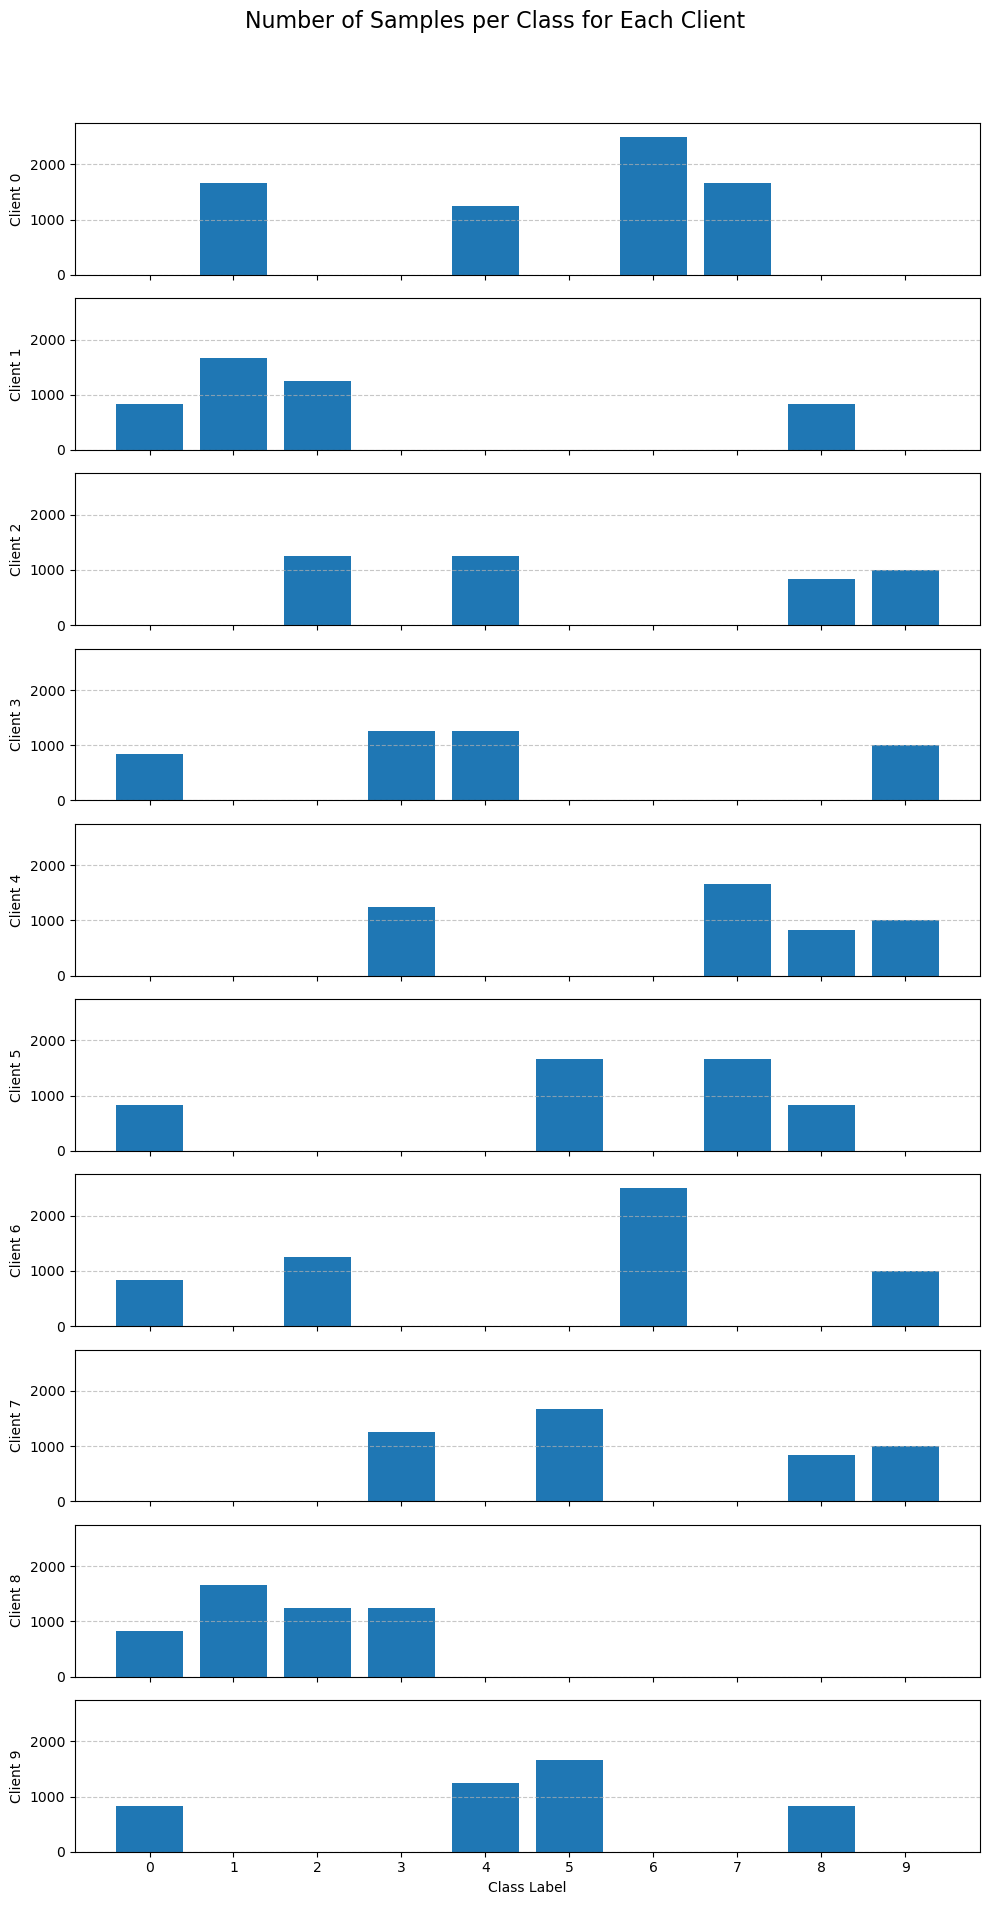

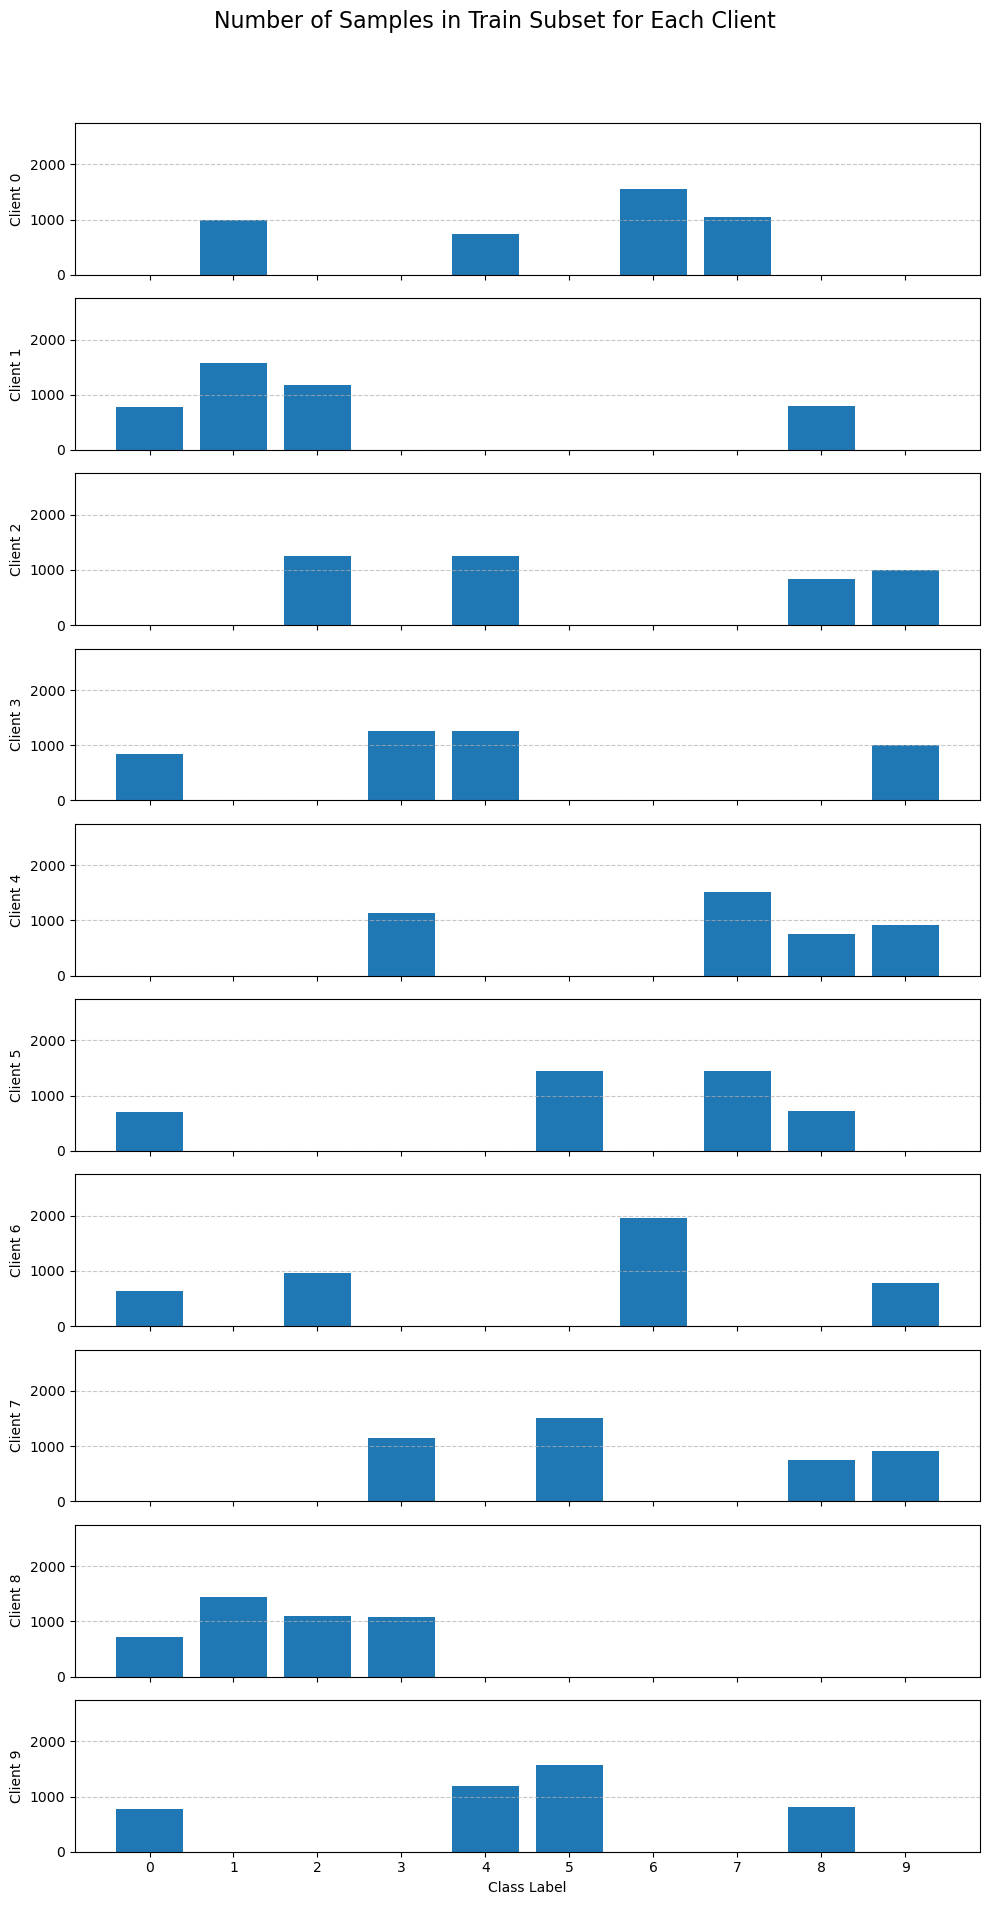

In [6]:
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader

# 各クライアントごとのクラスのデータ数をカウント
data_counts = []
for i in range(n_node):
    class_counts = [0] * 10  # クラス数は10と仮定
    for idx in node_indices[i]:
        label = train_dataset.targets[idx]
        class_counts[label] += 1
    data_counts.append(class_counts)

# クラスのデータ数の可視化
fig, axs = plt.subplots(n_node, 1, figsize=(10, 2 * n_node), sharex=True)
fig.suptitle('Number of Samples per Class for Each Client', fontsize=16)

x = np.arange(10)  # クラスラベル (0-9)

for i in range(n_node):
    axs[i].bar(x, data_counts[i])
    axs[i].set_ylabel(f'Client {i}')
    axs[i].set_ylim(0, max(max(data_counts[i]) for i in range(n_node)) * 1.1)
    axs[i].grid(axis='y', linestyle='--', alpha=0.7)

plt.xlabel('Class Label')
plt.xticks(x)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# train_subset_list の可視化
fig, axs = plt.subplots(n_node, 1, figsize=(10, 2 * n_node), sharex=True)
fig.suptitle('Number of Samples in Train Subset for Each Client', fontsize=16)

for i in range(n_node):
    loader = DataLoader(train_subset_list[i], batch_size=len(train_subset_list[i]), shuffle=False)
    batch = next(iter(loader))
    labels = batch[1].numpy()
    class_counts = [np.sum(labels == label) for label in range(10)]
    axs[i].bar(x, class_counts)
    axs[i].set_ylabel(f'Client {i}')
    axs[i].set_ylim(0, max(max(class_counts) for class_counts in data_counts) * 1.1)
    axs[i].grid(axis='y', linestyle='--', alpha=0.7)

plt.xlabel('Class Label')
plt.xticks(x)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
